# <small> <i>Task 9.</small> </i> Conway's Game of Life 

1. The universe of the Game of Life is a $N \times N$ square, two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, alive or dead. Every cell interacts with its eight neighbours, which are the cells that are horizontally, vertically, or diagonally adjacent (assume coordinates of neighbours modulo $N$). At each step in time, the following transitions occur:

  * Any live cell with two or three neighbours survives.
  * Any dead cell with three live neighbours becomes a live cell.
  * All other live cells die in the next generation. Similarly, all other dead cells stay dead.

2. Provide a parallel implementation for this Game of Life automaton, where each process should take some square (or rectangular, up to you) part of the grid.

3. Show the evolution of the grid and number of the living cells in time for different initial conditions (random and the well known ones, like "Gosper's gun").

1. Implement the game of life sequentially (1 point)

2. Provide a parallel implementation (2 points)

3. Your parallel implementation runs for any number of MPI processors, regardless of the number of cells (2 points)

4. Run the game with the "Gosper's glider gun" initial condition (1 point)

5. Model at least two more initial conditions (2 points)

6. Plot the number of the living cells vs time for the three initial conditions above (2 points)

### Sequential implementation
It was given to us

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
class grid_class(object):
    #initial = 0 - random, 1 - Gosper's glider gun
    def __init__(self,initial=0, size_x=100, size_y=100, coeff=0.5):
        if initial == 0:
            self.data=np.random.choice([0, 1], (size_x, size_y), replace=True, p=[coeff, 1.0-coeff])
            self.size_x=size_x
            self.size_y=size_y
            self.coeff=coeff
        elif initial == 1:
            self.size_x=38
            self.size_y=38
            self.data=np.zeros((self.size_y, self.size_x))
            y,x=1,5
            self.data[x:x+2,y:y+2]=1
            y,x=-3,3
            self.data[x:x+2,y:y+2]=1
            yx_1 = [[2,0],[3,0],[1,1],[0,2],[0,3],[0,4],[1,5],[2,6],[3,6],[4,3],[5,1],[6,2],[6,3],[6,4],[7,3],[5,5]]
            y,x=11,3
            for dy,dx in yx_1:
                self.data[x+dx,y+dy]=1
            y,x=21,1
            yx_2 = [[0,2],[0,3],[0,4],[1,2],[1,3],[1,4],[2,1],[2,5],[4,0],[4,1],[4,5],[4,6]]
            for dy,dx in yx_2:
                self.data[x+dx,y+dy]=1
        self.change=np.zeros(self.data.shape)
    
    def plot(self):
        figure(figsize=(10,10))
        imshow(self.data, aspect='auto', interpolation='none')
        gca().set_xticks([])
        gca().set_yticks([])
    
    def count_neighbours(self, i=0, j=0):
        count=0
        
        for incx in [-1,0,1]:
            for incy in [-1,0,1]:
                if ((incx!=0) or (incy!=0)):
                    ix=i+incx
                    iy=j+incy
                    
                    if ix==-1:
                        ix+=self.size_x;
                    elif ix==self.size_x:
                        ix=0
                        
                    if iy==-1:
                        iy+=self.size_y;
                    elif iy==self.size_y:
                        iy=0
                        
                    if self.data[ix,iy]==1:
                        count+=1
                    
        return count
    
    def update_change(self,i=0,j=0):
        count=self.count_neighbours(i,j)
        self.change[i,j]=0
        
        # if dead stay dead unless exactly three alive
        # if alive stay alive only when two or three alive
        # flip state otherwise
        if ((self.data[i,j]==0) and (count==3)) or ((self.data[i,j]==1) and ((count<2) or (count>3))):
            # self.data[i,j]=1-self.data[i,j]
            self.change[i,j]=1

        # return change
                        
    def one_time_step(self):
        # go through the map, update each cell
        change_count=0
        
        for i in arange(self.size_x):
            for j in arange(self.size_y):
                self.update_change(i,j)
        self.data = (self.data+self.change) %2
        change_count=sum(self.change)
        return change_count

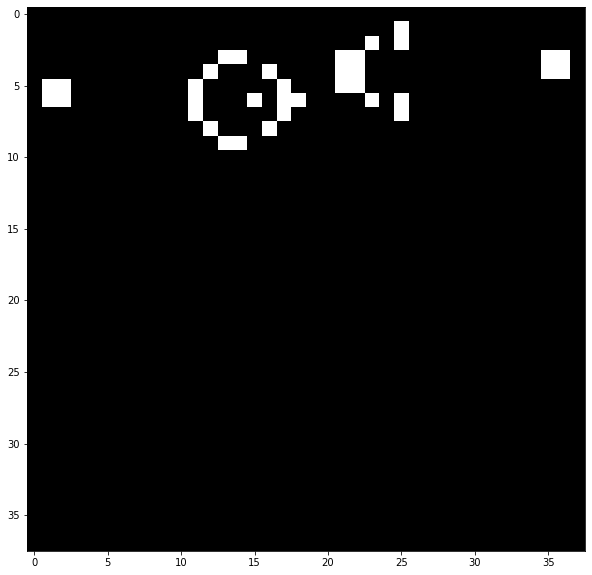

In [12]:
import copy
grid=grid_class(1) #Glider's gun
figure(figsize=(10,10))
imshow(grid.data, aspect='auto', cmap=bone(), interpolation='none')

!rm -rf grid_sequential*.png
!rm -rf movie_sequential.gif

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


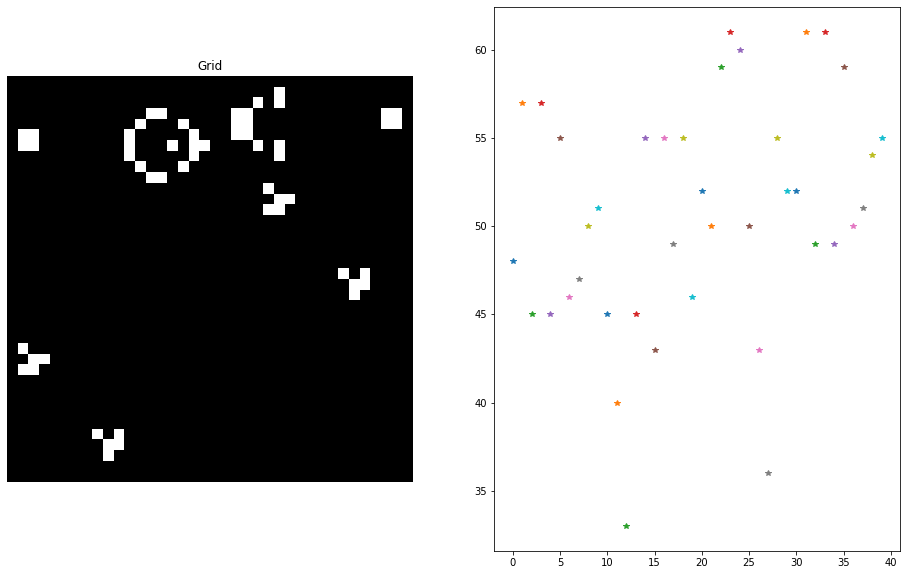

In [19]:
nofit=40

fig=figure(figsize=(16,10))

for n in arange(nofit):
    #--------------------------------------------------------
    bef=copy.deepcopy(grid.data)
    change_count=grid.one_time_step()      #updates all cells
    #--------------------------------------------------------
    ax2=subplot(121)
    ax2.imshow(grid.data, interpolation='none', cmap=bone())
    ax2.axis('off')
    ax2.set_title('Grid')
    
    ax5=subplot(122)
    ax5=plot(n, change_count, '*')
    #--------------------------------------------------------
    filename = 'grid_sequential_%04d.png' % n 
    savefig(filename, dpi=50)
    #--------------------------------------------------------
    if (array_equal(bef, grid.data)==True):
        break

In [20]:
# create a movie

from PIL import Image
import glob

# Create the frames
frames = []
imgs = sorted(glob.glob("grid_sequential*.png"))
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('movie_sequential.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

In [21]:
!rm -rf grid_sequential*.png

### A parallel implementation via ring topology

In [1]:
pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185365 sha256=f7e79a3b1c98b3a027596da39e0edec4f72290f92c00b5ccc3cdba8d070a0a56
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [48]:
%%writefile parallel_game.py

from mpi4py import MPI
import copy
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys

#for movie
from PIL import Image
import glob
#--------------------------------------------------------------------
#initial = 0 - random, 1 - Gosper's glider gun, 2 - pulsar (period 3), 3 - Penta-decathlon (period 15)
class grid_class(object):
    def __init__(self,initial=0, size_x=100, size_y=100, coeff=0.5): 
        if initial == 0:    #random
            self.data=np.random.choice([0, 1], (size_x, size_y), replace=True, p=[coeff, 1.0-coeff])
            self.size_x=size_x
            self.size_y=size_y
            self.coeff=coeff
            self.left_column=np.zeros(size_y)
            self.right_column=np.zeros(size_y)
            self.change=np.zeros(self.data.shape)
        elif initial == 1:  #Gosper's glider gun
            self.size_x=38
            self.size_y=38
            self.data=np.zeros((self.size_y, self.size_x))
            y,x=1,5
            self.data[x:x+2,y:y+2]=1
            y,x=-3,3
            self.data[x:x+2,y:y+2]=1
            yx_1 = [[2,0],[3,0],[1,1],[0,2],[0,3],[0,4],[1,5],[2,6],[3,6],[4,3],[5,1],[6,2],[6,3],[6,4],[7,3],[5,5]]
            y,x=11,3
            for dy,dx in yx_1:
                self.data[x+dx,y+dy]=1
            y,x=21,1
            yx_2 = [[0,2],[0,3],[0,4],[1,2],[1,3],[1,4],[2,1],[2,5],[4,0],[4,1],[4,5],[4,6]]
            for dy,dx in yx_2:
                self.data[x+dx,y+dy]=1
        elif initial == 2:  #Pulsar (period 3)
            self.size_x=17
            self.size_y=17
            self.data=np.zeros((self.size_y, self.size_x))

            xy1 = [[2,0],[3,0],[4,0],  [0,2],[0,3],[0,4]]

            x,y = 2,2
            for dx,dy in xy1:
                self.data[x+dx,y+dy]=1

            x,y = 2,14
            for dx,dy in xy1:
                self.data[x+dx,y-dy]=1

            x,y = 14,2
            for dx,dy in xy1:
                self.data[x-dx,y+dy]=1

            x,y = 14,14
            for dx,dy in xy1:
                self.data[x-dx,y-dy]=1

            xy2 = [[-1,0],[-2,0],[-3,0],  [0,-1],[0,-2],[0,-3]]

            x,y = 7,7
            for dx,dy in xy2:
                self.data[x+dx,y+dy]=1

            x,y = 9,7
            for dx,dy in xy2:
                self.data[x-dx,y+dy]=1

            x,y = 7,9
            for dx,dy in xy2:
                self.data[x+dx,y-dy]=1

            x,y = 9,9
            for dx,dy in xy2:
                self.data[x-dx,y-dy]=1

        elif initial == 3: # Penta-decathlon (period 15)
            self.size_x=11
            self.size_y=18
            self.data=np.zeros((self.size_y, self.size_x))
            x,y = 3,4
            xy1 = [[0,0],[0,1],[0,2],[1,1],[2,1],[3,0],[3,1],[3,2]]
            for dx,dy in xy1:
                self.data[x+dx,y+dy]=1
            x,y = 11,4
            for dx,dy in xy1:
                self.data[x+dx,y+dy]=1
            x,y = 8,4
            self.data[x:x+2,y:y+3]=1

        self.alive = np.zeros(0)
        self.game_type=["random","Gosper's glider gun","pulsar","Penta-decathlon"]
        
    def plot(self):
        figure(figsize=(10,10))
        imshow(self.data, aspect='auto', interpolation='none')
        gca().set_xticks([])
        gca().set_yticks([])
    
    def count_neighbours(self, i=0, j=0):
        count=0
        for incy in [-1,0,1]:
            for incx in [-1,0,1]:
                if ((incx!=0) or (incy!=0)):
                    ix=i+incx
                    iy=j+incy
                    
                    if iy==-1:
                        iy+=self.size_y;
                    elif iy==self.size_y:
                        iy=0

                    if ix==-1:
                        if self.left_column[iy]==1:
                          count+=1
                        continue
                    elif ix==self.size_x:
                        if self.right_column[iy]==1:
                          count+=1
                        continue
                        
                    if self.data[ix,iy]==1:
                        count+=1
                    
        return count
    
    def update_change(self,i=0,j=0):
        count=self.count_neighbours(i,j)
        self.change[i,j]=0
        
        # if dead stay dead unless exactly three alive
        # if alive stay alive only when two or three alive
        # flip state otherwise
        if ((self.data[i,j]==0) and (count==3)) or ((self.data[i,j]==1) and ((count<2) or (count>3))):
            # self.data[i,j]=1-self.data[i,j]
            self.change[i,j]=1

        # return change
                        
    def one_time_step(self):
        # go through the map, update each cell, update alive
        change_count=0
        
        for i in np.arange(self.size_x):
            for j in np.arange(self.size_y):
                self.update_change(i,j)
        self.data = (self.data+self.change) %2
        change_count=np.sum(self.change)

        self.alive=np.append(self.alive,np.sum(self.data))

        return change_count
#--------------------------------------------------------------
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

ring1d = comm.Create_cart(dims = [size], periods = True, reorder = False)
coord1d = ring1d.Get_coords(rank)
sender_x1, receiver_x1 = ring1d.Shift(0,1)   #send to the right
sender_x2, receiver_x2 = ring1d.Shift(0,-1)  #send to the left
#-----initial condition of the game and the number of frames---------
init_cond=int(sys.argv[1])
nofit=int(sys.argv[2])
if init_cond == 0:
    if rank==0:
        print(f'the initial conditions: random, number of frames: {nofit}')
    N = 50
    if rank != size-1:
        n = N//size
    else:
        n = N-(size-1)*(N//size)
    grid=grid_class(0,size_x=n,size_y=N,coeff=0.9) #n <-> x, N <-> y
elif init_cond == 1 or init_cond == 2 or init_cond == 3:
    if rank==0:
        if init_cond==1:
            print(f"the initial conditions: Gosper's slider gun, number of frames: {nofit}")
        elif init_cond==2:
            print(f"the initial conditions: Pulsar(rank 3), number of frames: {nofit}")
        elif init_cond==3:
            print(f"the initial conditions: Penta-decathlon (period 15), number of frames: {nofit}")

    grid=grid_class(init_cond) #n <-> x, N <-> y
    grid.data=np.array_split(grid.data,size,axis=0)[rank]
    grid.size_x=grid.data.shape[0]
    grid.size_y=grid.data.shape[1]
    grid.left_column=np.zeros(grid.size_y)
    grid.right_column=np.zeros(grid.size_y)
    grid.change=np.zeros(grid.data.shape)
else:
    if rank==0:
        print("please choose bewteen 0, 1 and 2 for initial condition")
    exit(1)

#--------------------------------------------------------------

if rank == 0:
    fig=plt.figure(figsize=(16,10))
for n in np.arange(nofit):
    #--------------------------------------------------------
    ring1d.Send(grid.data[-1], dest=receiver_x1)  #send to the right
    ring1d.Send(grid.data[0], dest=receiver_x2)  #send to the left

    ring1d.Recv(grid.left_column, source=sender_x1)  #recv from the left
    ring1d.Recv(grid.right_column, source=sender_x2)  #recv from the right
    #--------------------------------------------------------

    change_count=grid.one_time_step()      #updates all cells
    #--------------------------------------------------------
    if rank == 0:
        data_whole = np.empty((size,grid.size_x+1,grid.size_y))
    data_whole = comm.gather(grid.data)
    if rank == 0:
        data_whole=np.concatenate(data_whole,axis=0)

    count_total = comm.reduce(change_count, op=MPI.SUM, root=0)
    count_total=comm.bcast(count_total,root=0)
    #----plot a figure------------------------------------------
    if rank == 0:
        ax1=plt.subplot(121)
        ax1.imshow(data_whole, interpolation='none', cmap='bone')
        ax1.axis('off')
        ax1.set_title('Grid', fontsize = 20)


        ax2=plt.subplot(122)
        ax2=plt.plot(n, count_total, '*')

        #----save a figure---------------------------------------
        filename = 'grid_parallel_%04d.png' % n 
        plt.savefig(filename, dpi=50)
        #--------------------------------------------------------
    if (count_total==0):
        break

if rank==0:
    #the number of the alive cells vs time
    fig=plt.figure(figsize=(16,10))
    plt.plot(grid.alive)
    plt.title(f"The initial condition is:{grid.game_type[init_cond]} \n number of the alive cells vs time ", fontsize = 20)
    plt.xlabel("number of iteration", fontsize = 20)
    plt.xlabel("number of alive cells", fontsize = 20)
    filename = '%d_alive_graph.png' %init_cond 
    plt.savefig(filename, dpi=50)


    # create a movie
    # Create the frames
    frames = []
    imgs = sorted(glob.glob("grid_parallel*.png"))
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    moviename = '%d_movie_parallel.gif' %init_cond
    frames[0].save(moviename, format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=150, loop=0)


Overwriting parallel_game.py


In [49]:
!rm -rf grid_parallel*.png
!mpiexec -n 3 --allow-run-as-root python -m mpi4py parallel_game.py 0 10

the initial conditions: random, number of frames: 10
parallel_game.py:224: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(121)
parallel_game.py:230: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=plt.subplot(122)


In [50]:
!rm -rf grid_parallel*.png
!mpiexec -n 3 --allow-run-as-root python -m mpi4py parallel_game.py 1 40

the initial conditions: Gosper's slider gun, number of frames: 40
parallel_game.py:224: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(121)
parallel_game.py:230: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=plt.subplot(122)


In [51]:
!rm -rf grid_parallel*.png
!mpiexec -n 3 --allow-run-as-root python -m mpi4py parallel_game.py 2 17

the initial conditions: Pulsar(rank 3), number of frames: 17
parallel_game.py:224: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(121)
parallel_game.py:230: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=plt.subplot(122)


In [52]:
!rm -rf grid_parallel*.png
!mpiexec -n 3 --allow-run-as-root python -m mpi4py parallel_game.py 3 30

the initial conditions: Penta-decathlon (period 15), number of frames: 30
parallel_game.py:224: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(121)
parallel_game.py:230: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=plt.subplot(122)


In [55]:
!rm grid_parallel*.png

rm: cannot remove 'grid_parallel*.png': No such file or directory


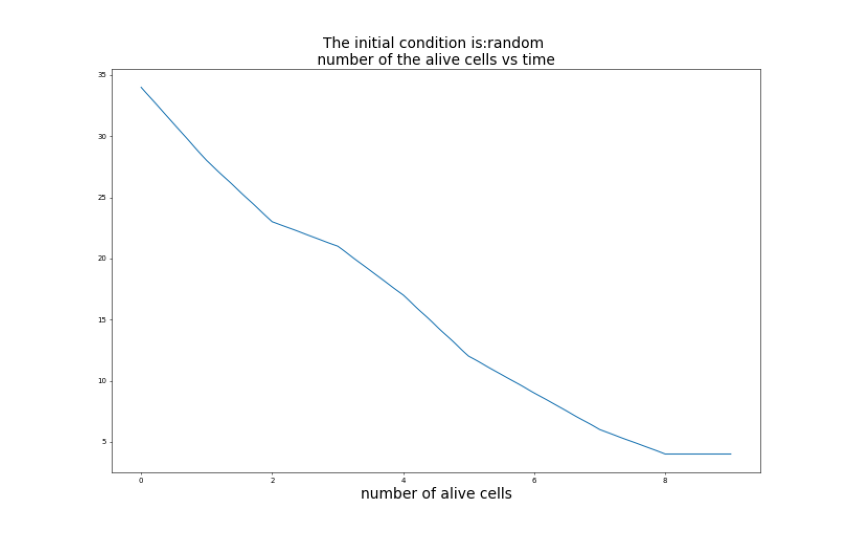

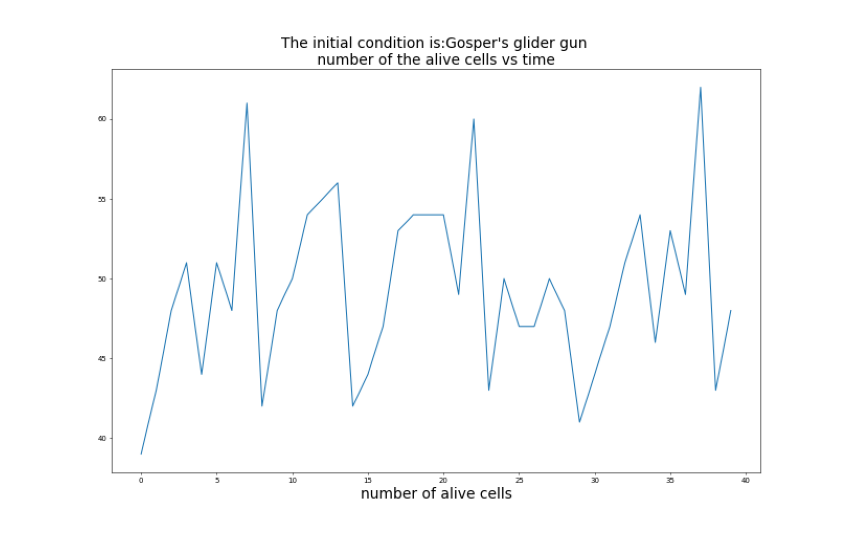

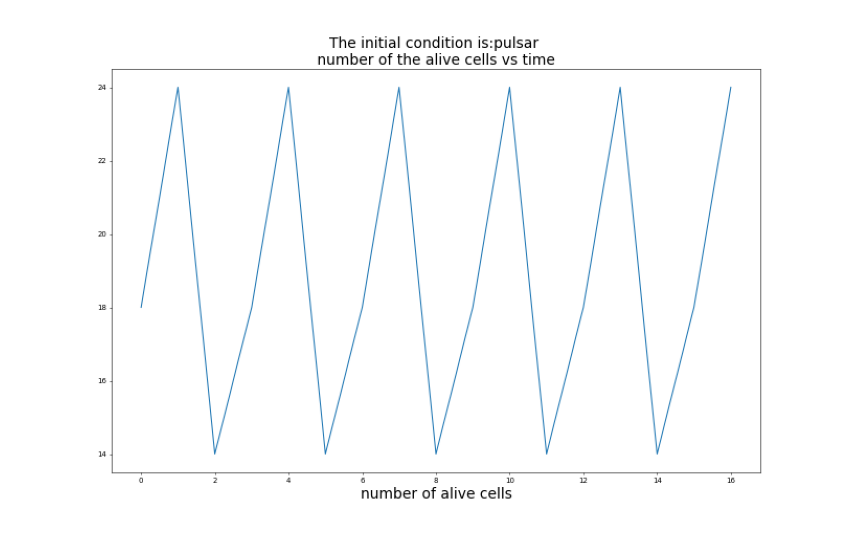

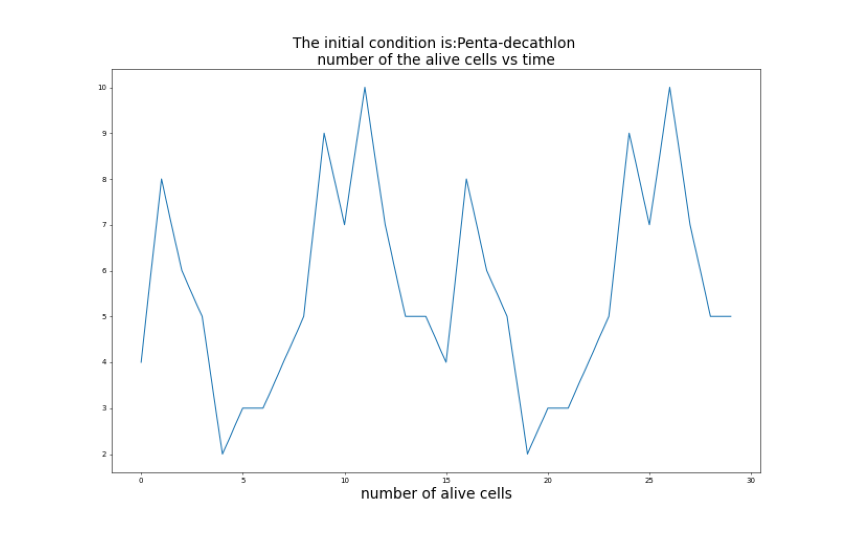

In [54]:
import matplotlib.image as mpimg
img = [mpimg.imread('%d_alive_graph.png'%i) for i in range(4)]
for i in range(4):   
    plt.figure(figsize=(15,10))
    imgplot = plt.imshow(img[i])
    plt.axis('off')
    plt.show()